In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

import flow

<h1> Public Water Supply </h1>

### Public Water Supply Withdrawals

The USGS 2015 dataset provides public water supply withdrawals directly under data codes 'PS-WGWFr', 'PS-WSWFr','PS-WGWSa', 'PS-WSWSa' for each county.

In [2]:
df = flow.prep_water_use_2015(variables=['State','County','PS-WGWFr', 'PS-WSWFr','PS-WGWSa', 'PS-WSWSa'])
df.head()               

,State,County,PS-WGWFr,PS-WSWFr,PS-WGWSa,PS-WSWSa
0,AL,Autauga County,3.64,0.00,0.0,0.0
1,AL,Baldwin County,23.67,0.00,0.0,0.0
2,AL,Barbour County,3.23,0.00,0.0,0.0
3,AL,Bibb County,5.18,0.00,0.0,0.0
4,AL,Blount County,2.78,54.08,0.0,0.0


### Public Water Supply Deliveries, Exports, and Imports

The USGS 2015 dataset provide public water supply data in three categories: (1) total public water supply withdrawals, (2) public water supply deliveries to domestic end users, and (3) public water supply deliveries to thermoelectric cooling.

The 1995 USGS dataset provides public water supply deliveries to domestic, industrial, commercial, thermoelectric cooling, and losses/exports separately. To estimate the deliveries to commercial and industrial customers in 2015, the ratio of each to the sum of deliveries to residential and thermoelectric cooling is calculated from the 1995 data. These ratios are applied to the 2015 residential and thermoelectric cooling public water supply delivery values. 

Additionally, public water suppy exports and imports are calculated. When the sum of water deliveries is greater than the water withdrawn for public water supply, the difference is considered to be imported. When water withdrawn is greater, excess water after deliveries is considered to be exported.

Caveats and assumptions:
* This methodology assumes that if no public water supply was delivered to residential or thermoelectric cooling in 1995, then deliveries to industrial and commercial sectors would likewise be zero.

In [19]:
df = flow.calc_pws_discharge()
df['PS-loss'] = .50*df['PS-EX']
df['PS-EX'] = .50*df['PS-EX']
df['loss_frac'] = df['PS-loss']/(df['PS-Wtotl']+df["PS-IX"])
df.describe()

,PS-Wtotl,DO-PSDel,PT-PSDel,CO-PSDel,IN-PSDel,PS-IX,PS-EX,PS-del,PS-loss,loss_frac
count,3223.000000,3223.000000,3223.000000,3221.000000,3221.000000,3223.000000,3223.000000,3221.000000,3223.000000,3220.000000
mean,12.100344,7.227394,0.068300,2.338773,1.590918,2.393123,1.635159,11.229846,1.635159,0.091771
std,46.049513,27.848547,1.065014,10.166218,5.474163,12.338653,9.809169,39.598662,9.809169,0.113350
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.810000,0.580000,0.000000,0.073714,0.000000,0.000000,0.000000,0.817308,0.000000,0.000000
50%,2.280000,1.460000,0.000000,0.302145,0.124815,0.000000,0.053636,2.216296,0.053636,0.047744
75%,6.900000,4.070000,0.000000,1.120571,0.894285,0.454253,0.423898,6.847914,0.423898,0.156799
max,1256.440000,817.880000,46.650000,278.650387,94.857376,279.921484,279.037143,1115.468888,279.037143,0.496693


In [3]:
df = flow.prep_water_use_1995()
df = df[['PS-WTotl','PS-DelDO','PS-DelCO','PS-DelIN', "PS-UsLos", 'PS-DelPT','PS-DelTO']]

df["sum_del"] = df['PS-DelDO']+df['PS-DelCO']+df['PS-DelIN']+df['PS-DelPT']
df['with_dif'] = df['PS-WTotl'] - df["PS-UsLos"]
#df["del_diff"] = df['PS-DelTO']-df["sum_del"]
df["with_dif"].describe()

count    3225.000000
mean       10.626726
std        42.081375
min         0.000000
25%         0.800000
50%         2.050000
75%         5.650000
max      1444.800000
Name: with_dif, dtype: float64

In [7]:
df = flow.prep_water_use_1995()
df = df[['PS-DelDO', 'PS-DelCO','PS-DelIN', "PS-UsLos"]]
df.describe()

,PS-DelDO,PS-DelCO,PS-DelIN,PS-UsLos
count,3225.000000,3225.000000,3225.000000,3225.000000
mean,7.044995,2.077039,1.473600,1.856552
std,30.250255,9.416361,5.694688,24.596557
min,0.000000,0.000000,0.000000,-354.120000
25%,0.570000,0.080000,0.000000,0.040000
50%,1.360000,0.270000,0.120000,0.260000
75%,3.600000,0.980000,0.760000,0.980000
max,1058.380000,287.590000,100.270000,482.680000


In [ ]:
df = flow.prep_water_use_2015()


# Intensities & Percentages

#### Conveyance Losses as a Percent of Water Withdrawn for Irrigation
Conveyance loss fraction for irrigation is calculated from the USGS 1995 water use dataset. It is calculated as the total conveyance losses (MGD) divided by the total water withdrawn (MGD) for irrigation. Looking at the fractions at the county level shows that a small subset of counties have unreliable values where conveyance losses are far greater than the amount withdrawn for irrigation. As a result, the ability to cap the loss fraction at a specified amount it provided and replace it with the average of the specified region. The default loss cap fraction is .90.

In [24]:
df = flow.prep_water_use_1995()
df = flow.calc_conveyance_loss_frac(df)
df.head()

,FIPS,State,County,IR_CLoss_Frac
0,01001,AL,Autauga,0.0
1,01003,AL,Baldwin,0.0
2,01005,AL,Barbour,0.0
3,01007,AL,Bibb,0.0
4,01009,AL,Blount,0.0


##### Change in loss cap

In [22]:
df = flow.prep_water_use_1995()
df = flow.calc_conveyance_loss_frac(df, loss_cap_amt=.20)
df.head()

,FIPS,State,County,IR_CLoss_Frac
0,01001,AL,Autauga,0.0
1,01003,AL,Baldwin,0.0
2,01005,AL,Barbour,0.0
3,01007,AL,Bibb,0.0
4,01009,AL,Blount,0.0


In [26]:
help(flow.plot_bar)

Help on function plot_bar in module flow.visualize:

plot_bar(data, x, y, region, y_axis='Value', x_axis_title='Region', y_axis_title='Value')
    Plot the results of a cerf run on a map where each technology has its own color.
    :param df:                       Result data frame from running 'cerf.run()'
    :type df:                        DataFrame
    :param boundary_shp:                    Full path to a boundary shapefile with file name and extension.  If no file
                                            provided, the default boundary for the CONUS will be used.
    :type boundary_shp:                     str
    :param regions_shp:                     Full path to a regions shapefile with file name and extension.  If no file
                                            provided, the default regions for the CONUS will be used.
    :type regions_shp:                      str
    :param column:                          Column to plot
    :type column:                           s

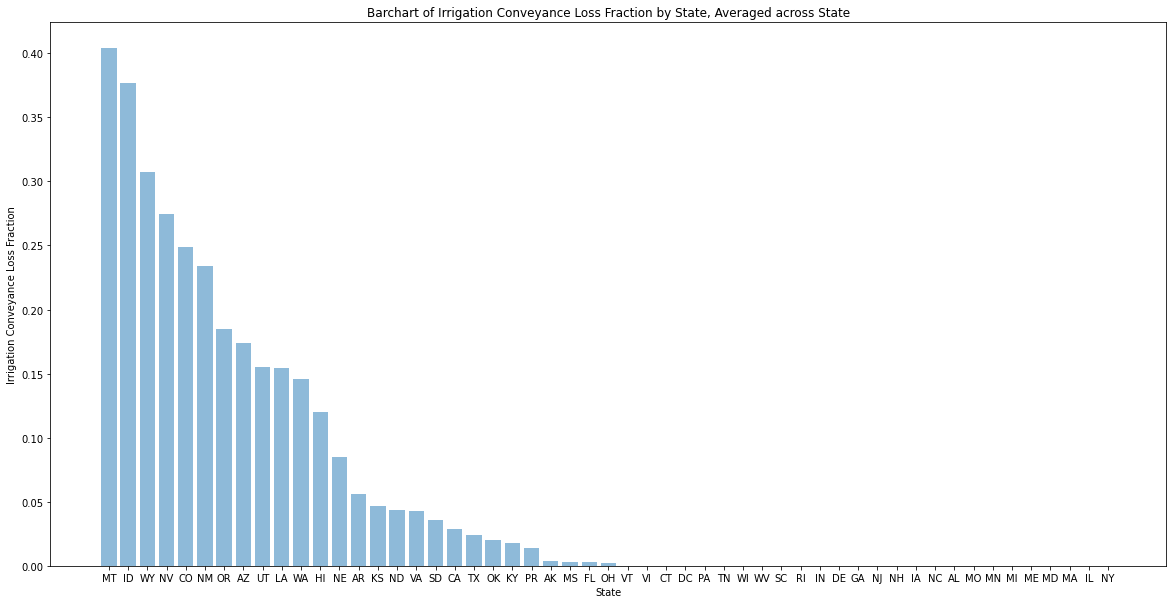

In [25]:
flow.plot_bar(df, "State","IR_CLoss_Frac", "State", y_axis_title = "Irrigation Conveyance Loss Fraction", x_axis_title="State")

#### Water Use Intensity for Hydroelectric Generation

In [31]:
df = flow.calc_hydroelectric_water_intensity(intensity_cap=True, intensity_cap_amt=165, region_avg=False)

df.head()

,State,HY_IF
0,AL,31.055819
1,AL,NaN
2,AL,NaN
3,AL,NaN
4,AL,NaN


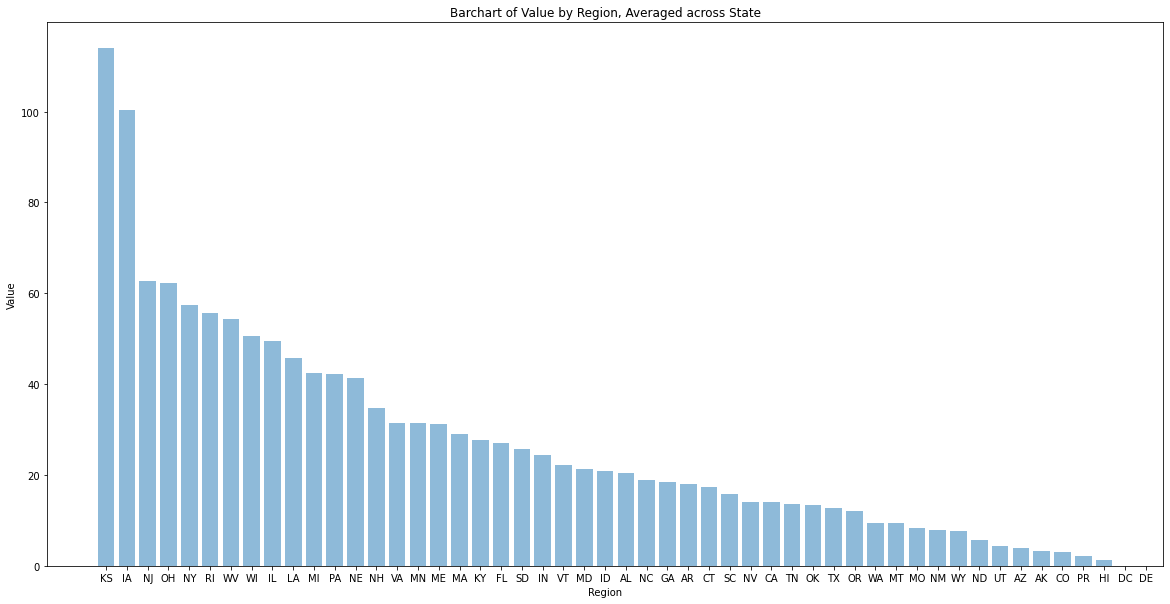

In [32]:
flow.plot_bar(df, "State","HY_IF", "State")